<font size="6">**Team 01 - Datathon - Machine Learning**</font>

# Objective : 
This notebook goes through in detail the building and evaluation of the prediction models for VitalDB dataset

# Executive Summary 

1. The best performing model is the Extreme Gradient Boosting GBM model with auc of 0.9134.
2. The important variables that contributed towards the above prediction accuracy are:
    - optype_7 - Transplanation 
    - b4_lac - Lactive
    - b4_be - Base Excess

# Machine Learnig Classification Models

## Import libararies

In [261]:
#import libararies
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected = True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly import tools

from sklearn.impute import SimpleImputer


import model_func
#to make sure kernel restart is not needed after making changes in .py
import importlib
importlib.reload(model_func)


from xgboost import XGBClassifier


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_curve, roc_auc_score, auc


from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from datetime import datetime

import random
import warnings
warnings.filterwarnings("ignore")
from time import time
from sklearn.metrics import f1_score, accuracy_score

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import shap


In [262]:
df =  pd.read_excel('01_data_compiled_selected_patients_4221.xlsx')
print(df.shape)

(4221, 84)


In [263]:
#display all columns
pd.set_option("display.max_columns",None)
df.head()

caseid  complications  icu_days  death_inhosp  pre_post_cr   age  sex  \
0       1              0         0             0     0.878049  77.0    0   
1       2              0         0             0     0.953488  54.0    0   
2       7              1         3             0          NaN  52.0    1   
3       9              0         0             0          NaN  32.0    1   
4      10              0         1             0     0.725000  72.0    0   

   height  weight   bmi    asa            optype     approach  emop ane_type  \
0   160.2   67.50  26.3  cat02        Colorectal         Open     0  General   
1   167.3   54.80  19.6  cat02           Stomach         Open     0  General   
2   167.7   62.30  22.2  cat02   Major resection  Videoscopic     0  General   
3   157.9   50.90  20.4  cat01  Biliary/Pancreas  Videoscopic     0  General   
4   162.5   62.75  23.8  cat03           Stomach  Videoscopic     0  General   

   preop_htn  preop_dm preop_pft  optype_00  optype_01  optype_02  optype_03  \
0          1         0    Normal          1          0          0          0   
1          0         0    Normal          0          0          1          0   
2          0         0    Normal          0          0          0          1   
3          0         0    Normal          0          1          0          0   
4          1         0    Normal          0          0          1          0   

   optype_04  optype_05  optype_06  optype_07  optype_08  optype_09  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   optype_10  approach_00  approach_01  approach_02  ane_type_00  ane_type_01  \
0          0            1            0            0            1            0   
1          0            1            0            0            1            0   
2          0            0            1            0            1            0   
3          0            0            1            0            1            0   
4          0            0            1            0            1            0   

   ane_type_02  preop_pft_00  preop_pft_01  preop_pft_02  preop_pft_03  \
0            0             1             0             0             0   
1            0             1             0             0             0   
2            0             1             0             0             0   
3            0             1             0             0             0   
4            0             1             0             0             0   

   preop_pft_04  preop_pft_05  preop_pft_06  preop_pft_07  preop_pft_08  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   asa_00  asa_01  asa_02  asa_03  asa_04  asa_05  b4_alb  b4_alt  b4_ammo  \
0       1       0       0       0       0       0     3.4    20.0      NaN   
1       1       0       0       0       0       0     3.1    19.0      NaN   
2       1       0       0       0       0       0     4.4    16.0      NaN   
3       0       1       0       0       0       0     4.4     8.0      NaN   
4       0       0       1       0       0       0     3.2    54.0      NaN   

   b4_aptt  b4_ast  b4_be  b4_bun  b4_ccr  b4_cl  b4_cr  b4_crp  b4_esr  \
0     28.0    20.0    NaN    15.0     NaN  100.0   0.88   22.41     NaN   
1     28.6    29.0    NaN    12.0     NaN  115.0   1.02   16.18     NaN   
2     26.4    20.0    0.8    18.0     NaN  106.0   0.84    0.09     NaN   
3    

## Feature Engineering 

In [264]:
df['complications'].value_counts()

complications
0    3957
1     264
Name: count, dtype: int64

1. **height &  weight** removed because of BMI 
2. **death_inhosp, pre_post_cr & icu_days** removed to avoid target leakage
3. **optype** - One-Hot encoding (OHE) 
4. **approach**-OHE 
5. **ane_type**- OHE 
6. **preop_pft** - OHE
7. **asa** - OHE 

In [265]:
#dropping not required and categorical features
df= df.drop(['death_inhosp','caseid','icu_days','height','weight','pre_post_cr','approach',\
             'ane_type','asa', 'optype','preop_pft'],axis= 1)

In [266]:
df.head()

complications   age  sex   bmi  emop  preop_htn  preop_dm  optype_00  \
0              0  77.0    0  26.3     0          1         0          1   
1              0  54.0    0  19.6     0          0         0          0   
2              1  52.0    1  22.2     0          0         0          0   
3              0  32.0    1  20.4     0          0         0          0   
4              0  72.0    0  23.8     0          1         0          0   

   optype_01  optype_02  optype_03  optype_04  optype_05  optype_06  \
0          0          0          0          0          0          0   
1          0          1          0          0          0          0   
2          0          0          1          0          0          0   
3          1          0          0          0          0          0   
4          0          1          0          0          0          0   

   optype_07  optype_08  optype_09  optype_10  approach_00  approach_01  \
0          0          0          0          0            1            0   
1          0          0          0          0            1            0   
2          0          0          0          0            0            1   
3          0          0          0          0            0            1   
4          0          0          0          0            0            1   

   approach_02  ane_type_00  ane_type_01  ane_type_02  preop_pft_00  \
0            0            1            0            0             1   
1            0            1            0            0             1   
2            0            1            0            0             1   
3            0            1            0            0             1   
4            0            1            0            0             1   

   preop_pft_01  preop_pft_02  preop_pft_03  preop_pft_04  preop_pft_05  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   preop_pft_06  preop_pft_07  preop_pft_08  asa_00  asa_01  asa_02  asa_03  \
0             0             0             0       1       0       0       0   
1             0             0             0       1       0       0       0   
2             0             0             0       1       0       0       0   
3             0             0             0       0       1       0       0   
4             0             0             0       0       0       1       0   

   asa_04  asa_05  b4_alb  b4_alt  b4_ammo  b4_aptt  b4_ast  b4_be  b4_bun  \
0       0       0     3.4    20.0      NaN     28.0    20.0    NaN    15.0   
1       0       0     3.1    19.0      NaN     28.6    29.0    NaN    12.0   
2       0       0     4.4    16.0      NaN     26.4    20.0    0.8    18.0   
3       0       0     4.4     8.0      NaN      NaN    13.0    NaN     NaN   
4       0       0     3.2    54.0      NaN     27.3    57.0    NaN    18.0   

   b4_ccr  b4_cl  b4_cr  b4_crp  b4_esr  b4_fib  b4_gfr  b4_gluc  b4_hb  \
0     NaN  100.0   0.88   22.41     NaN   254.0    83.8    198.0   13.4   
1     NaN  115.0   1.02   16.18     NaN   290.0    75.9    118.0   10.2   
2     NaN  106.0   0.84    0.09     NaN   271.0    70.9     94.0   11.8   
3     NaN    NaN    NaN     NaN     NaN     NaN     NaN      NaN   12.8   
4     NaN  104.0   1.15    0.10     NaN   336.0    62.5    315.0   13.6   

   b4_hco3  b4_hct  b4_ica  b4_k  b4_lac  b4_na  b4_p  b4_pco2  b4_ph  b4_plt  \
0      NaN    38.9     NaN   3.1     NaN  138.0   NaN      NaN    NaN   146.0   
1      NaN    32.5     NaN   4.7     NaN  143.0   NaN      NaN    NaN   251.0   
2     25.4    35.1    1.17   4.4     1.2  139.0   NaN     47.0   7.34   229.0   
3      NaN    39.5     NaN   NaN     NaN    NaN   NaN      NaN    NaN   133.0

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   complications  4221 non-null   int64  
 1   age            4221 non-null   float64
 2   sex            4221 non-null   int64  
 3   bmi            4221 non-null   float64
 4   emop           4221 non-null   int64  
 5   preop_htn      4221 non-null   int64  
 6   preop_dm       4221 non-null   int64  
 7   optype_00      4221 non-null   int64  
 8   optype_01      4221 non-null   int64  
 9   optype_02      4221 non-null   int64  
 10  optype_03      4221 non-null   int64  
 11  optype_04      4221 non-null   int64  
 12  optype_05      4221 non-null   int64  
 13  optype_06      4221 non-null   int64  
 14  optype_07      4221 non-null   int64  
 15  optype_08      4221 non-null   int64  
 16  optype_09      4221 non-null   int64  
 17  optype_10      4221 non-null   int64  
 18  approach

In [268]:
# Check for missing values in each column and sum them up
missing_values = df.isnull().sum()

# Filter columns with missing values (count > 0)
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with Missing Values:")
print(columns_with_missing_values)


Columns with Missing Values:
b4_alb       266
b4_alt       265
b4_ammo     4161
b4_aptt      798
b4_ast       265
b4_be       3552
b4_bun       330
b4_ccr      4088
b4_cl        264
b4_cr        330
b4_crp       718
b4_esr      3800
b4_fib       913
b4_gfr       340
b4_gluc      652
b4_hb        292
b4_hco3     3336
b4_hct       289
b4_ica      2974
b4_k         260
b4_lac      3338
b4_na        260
b4_p        2158
b4_pco2     3336
b4_ph       3336
b4_plt       294
b4_po2      3336
b4_pt%       795
b4_ptinr     795
b4_ptsec     795
b4_sao2     3336
b4_tbil      266
b4_tprot     266
b4_wbc       292
dtype: int64


## Correlation 

In [269]:
data_corr = df.select_dtypes(include=[np.number])
#Generate correlation matrix
corrMatrix = data_corr.corr()
corrMatrix.head(20)

complications       age       sex       bmi  emop  preop_htn  \
complications       1.000000 -0.008909 -0.074019 -0.064579   NaN   0.011674   
age                -0.008909  1.000000 -0.094336  0.057388   NaN   0.351691   
sex                -0.074019 -0.094336  1.000000 -0.010117   NaN  -0.069687   
bmi                -0.064579  0.057388 -0.010117  1.000000   NaN   0.173192   
emop                     NaN       NaN       NaN       NaN   NaN        NaN   
preop_htn           0.011674  0.351691 -0.069687  0.173192   NaN   1.000000   
preop_dm            0.019478  0.167679 -0.054123  0.053262   NaN   0.148003   
optype_00          -0.077737  0.147385 -0.051815 -0.015822   NaN   0.054002   
optype_01          -0.051351  0.009352  0.044785  0.058730   NaN   0.013575   
optype_02          -0.049691  0.060796 -0.047986 -0.064460   NaN   0.005444   
optype_03           0.013071  0.077954 -0.017575  0.046188   NaN   0.033480   
optype_04           0.050824 -0.074684 -0.033683 -0.090875   NaN  -0.065367   
optype_05          -0.053772  0.016481  0.025327  0.016686   NaN  -0.015935   
optype_06          -0.047760 -0.084343  0.220815  0.044581   NaN  -0.046769   
optype_07           0.340179 -0.233618 -0.008011 -0.064793   NaN  -0.018890   
optype_08          -0.053879 -0.138941  0.080503  0.096490   NaN  -0.061722   
optype_09          -0.016550  0.032380 -0.101409  0.021904   NaN   0.015168   
optype_10           0.031644  0.014413 -0.035286 -0.016518   NaN   0.052810   
approach_00         0.082909 -0.032829  0.006697 -0.069514   NaN   0.006331   
approach_01        -0.074514  0.055303  0.010856  0.039060   NaN   0.000672   

               preop_dm  optype_00  optype_01  optype_02  optype_03  \
complications  0.019478  -0.077737  -0.051351  -0.049691   0.013071   
age            0.167679   0.147385   0.009352   0.060796   0.077954   
sex           -0.054123  -0.051815   0.044785  -0.047986  -0.017575   
bmi            0.053262  -0.015822   0.058730  -0.064460   0.046188   
emop                NaN        NaN        NaN        NaN        NaN   
preop_htn      0.148003   0.054002   0.013575   0.005444   0.033480   
preop_dm       1.000000   0.007365   0.044605   0.023271   0.026733   
optype_00      0.007365   1.000000  -0.210191  -0.188207  -0.193184   
optype_01      0.044605  -0.210191   1.000000  -0.129964  -0.133400   
optype_02      0.023271  -0.188207  -0.129964   1.000000  -0.119448   
optype_03      0.026733  -0.193184  -0.133400  -0.119448   1.000000   
optype_04     -0.024538  -0.187011  -0.129138  -0.115632  -0.118689   
optype_05     -0.005340  -0.189637  -0.130951  -0.117255  -0.120355   
optype_06     -0.053603  -0.112674  -0.077805  -0.069668  -0.071510   
optype_07     -0.033947  -0.140188  -0.096805  -0.086680  -0.088972   
optype_08     -0.048026  -0.115083  -0.079469  -0.071157  -0.073039   
optype_09     -0.002554  -0.129372  -0.089336  -0.079993  -0.082108   
optype_10      0.029728  -0.085059  -0.058736  -0.052593  -0.053984   
approach_00   -0.020521   0.236181  -0.092184  -0.179588  -0.249130   
approach_01    0.022593  -0.192367   0.067934   0.188852   0.163801   

               optype_04  optype_05  optype_06  optype_07  optype_08  \
complications   0.050824  -0.053772  -0.047760   0.340179  -0.053879   
age            -0.074684   0.016481  -0.084343  -0.233618  -0.138941   
sex            -0.033683   0.025327   0.220815  -0.008011   0.080503   
bmi            -0.090875   0.016686   0.044581  -0.064793   0.096490   
emop                 NaN        NaN        NaN        NaN        NaN   
preop_htn      -0.065367  -0.015935  -0.046769  -0.018890  -0.061722   
preop_dm       -0.024538  -0.005340  -0.053603  -0.033947  -0.048026   
optype_00      -0.187011  -0.189637  -0.112674  -0.140188  -0.115083   
optype_01      -0.129138  -0.130951  -0.077805  -0.096805  -0.079469   
optype_02      -0.115632  -0.117255  -0.069668  -0.086680  -0.071157   
optype_03      -0.118689  -0.120355  -0.071510  -0.088972  -0.073039   

In [270]:
#show the correlation with respect to target variable
corrMatrix.sort_values(['complications'], ascending=False, inplace=True)
corrMatrix['complications']

complications    1.000000
b4_lac           0.389624
b4_be            0.350902
optype_07        0.340179
b4_ccr           0.235137
                   ...   
b4_alb          -0.167970
b4_pco2         -0.175784
b4_pt%          -0.198685
b4_hco3         -0.271107
emop                  NaN
Name: complications, Length: 73, dtype: float64

In [271]:
#show the correlation with respect to target variable
corrMatrix.sort_values(['complications'], ascending=False, inplace=True)
corrMatrix['complications']

complications    1.000000
b4_lac           0.389624
b4_be            0.350902
optype_07        0.340179
b4_ccr           0.235137
                   ...   
b4_alb          -0.167970
b4_pco2         -0.175784
b4_pt%          -0.198685
b4_hco3         -0.271107
emop                  NaN
Name: complications, Length: 73, dtype: float64

## Train - Test Split

In [272]:
# X - all the feature columns except target variable
X= df.drop(['complications'],axis= 1)
# y - target variable
y= df['complications']

#80% training data set and 20% validation set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print("%r, %r, %r" % (X.shape, X_train.shape, X_test.shape))

(4221, 72), (3376, 72), (845, 72)


## Simple Imputer

In [273]:
#imputing for model that are not able to handle missing values. 
nan_col =  df.filter(regex='b4').columns.to_list()

X_train_imputed=X_train.copy()
X_test_imputed=X_test.copy()

#fit training data col
imp = SimpleImputer()

# transform training data column 
X_train_imputed[nan_col] =pd.DataFrame(imp.fit_transform(X_train[nan_col]),
                   columns=nan_col,index=X_train.index)

#transform the testing data column
X_test_imputed[nan_col]=pd.DataFrame(imp.transform(X_test[nan_col]),
                   columns=nan_col,index=X_test.index)

# Modeling

## Variation 1: XGBM without imputation

In [274]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.9425132930591164, 'gamma': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 100, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.705941802151484}


In [275]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_1.sav',X_train,y_train)

XGB Classifier
Start Time: 2024-04-29 20:16:21.448291
End Time: 2024-04-29 20:16:21.794144
Total time taken:0:00:00.345853


In [276]:
model_func.c_matrix('xgbm_1.sav','Post-Operative Complications',y_test,X_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.70      0.36      0.47        53

    accuracy                           0.95       845
   macro avg       0.83      0.67      0.72       845
weighted avg       0.94      0.95      0.94       845



In [277]:
model_func.plot_auc('xgbm_1.sav',y_test,X_test)

In [278]:
model_func.feature_importance('xgbm_1.sav',X_train,"Top Important Features")

## Variation 2: XGBM with Simple Imputation

In [279]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.619260501928012, 'gamma': 6.4, 'learning_rate': 0.1, 'max_depth': 4, 'max_leaves': 100, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0, 'subsample': 0.5995902187716171}


In [280]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_2.sav',X_train_imputed,y_train)

XGB Classifier
Start Time: 2024-04-29 20:16:31.009810
End Time: 2024-04-29 20:16:31.151515
Total time taken:0:00:00.141705


In [281]:
model_func.c_matrix('xgbm_2.sav','Post-Operative Complications',y_test,X_test_imputed)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.67      0.38      0.48        53

    accuracy                           0.95       845
   macro avg       0.81      0.68      0.73       845
weighted avg       0.94      0.95      0.94       845



In [282]:
model_func.plot_auc('xgbm_2.sav',y_test,X_test_imputed)

In [283]:
model_func.feature_importance('xgbm_2.sav',X_train_imputed,"Top Important Features")

## Variation 3: XGBoost with Median Imputation

In [284]:
## Simple Imputer with Median Strategy
X_train_median_imputed = X_train.copy()
X_test_median_imputed = X_test.copy()

# Create a SimpleImputer with median strategy
imp_median = SimpleImputer(strategy='median')

# Transform training data columns
X_train_median_imputed[nan_col] = pd.DataFrame(imp_median.fit_transform(X_train[nan_col]), columns=nan_col, index=X_train.index)

# Transform testing data columns
X_test_median_imputed[nan_col] = pd.DataFrame(imp_median.transform(X_test[nan_col]), columns=nan_col, index=X_test.index)


In [285]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_median_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.7040901154600012, 'gamma': 3.2, 'learning_rate': 0.3, 'max_depth': 6, 'max_leaves': 80, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.9553778451534392}


In [286]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_3.sav',X_train_median_imputed,y_train)

XGB Classifier
Start Time: 2024-04-29 20:16:36.337995
End Time: 2024-04-29 20:16:36.388248
Total time taken:0:00:00.050253


In [287]:
model_func.c_matrix('xgbm_3.sav','Post-Operative Complications',y_test,X_test_median_imputed)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.67      0.34      0.45        53

    accuracy                           0.95       845
   macro avg       0.81      0.66      0.71       845
weighted avg       0.94      0.95      0.94       845



In [288]:

model_func.plot_auc('xgbm_3.sav',y_test,X_test_median_imputed)

In [289]:
model_func.feature_importance('xgbm_3.sav',X_train_median_imputed,"Top Important Features")

## Variation 4: XGBoost with Mean Imputation

In [290]:
## Simple Imputer with Mean Strategy
X_train_mean_imputed = X_train.copy()
X_test_mean_imputed = X_test.copy()

# Create a SimpleImputer with mean strategy
imp_mean = SimpleImputer(strategy='mean')

# Transform training data columns
X_train_mean_imputed[nan_col] = pd.DataFrame(imp_mean.fit_transform(X_train[nan_col]), columns=nan_col, index=X_train.index)

# Transform testing data columns
X_test_mean_imputed[nan_col] = pd.DataFrame(imp_mean.transform(X_test[nan_col]), columns=nan_col, index=X_test.index)


In [291]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_mean_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.4612965152077934, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'max_leaves': 40, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.8918748980892741}


In [292]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_4.sav',X_train_mean_imputed,y_train)

XGB Classifier
Start Time: 2024-04-29 20:16:41.786522
End Time: 2024-04-29 20:16:41.864895
Total time taken:0:00:00.078373


In [293]:
model_func.c_matrix('xgbm_4.sav','Post-Operative Complications',y_test,X_test_mean_imputed)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.69      0.34      0.46        53

    accuracy                           0.95       845
   macro avg       0.82      0.66      0.71       845
weighted avg       0.94      0.95      0.94       845



In [294]:

model_func.plot_auc('xgbm_4.sav',y_test,X_test_mean_imputed)

In [295]:
model_func.feature_importance('xgbm_4.sav',X_train_mean_imputed,"Top Important Features")

## Variation 5: XGBoost with Median Imputation on 50% Completeness

In [296]:
# Define a threshold for missing values (e.g., 50%)
missing_value_threshold = 0.5

# Identify columns with missing values more than the threshold
columns_complete_50 = df[nan_col].columns[df[nan_col].isna().mean() <= missing_value_threshold].tolist()
print(columns_complete_50)

# # Identify columns with missing values more than the threshold
# columns_incomplete_50 = df[nan_col].columns[df[nan_col].isna().mean() > missing_value_threshold].tolist()
# print(columns_incomplete_50)

['b4_alb', 'b4_alt', 'b4_aptt', 'b4_ast', 'b4_bun', 'b4_cl', 'b4_cr', 'b4_crp', 'b4_fib', 'b4_gfr', 'b4_gluc', 'b4_hb', 'b4_hct', 'b4_k', 'b4_na', 'b4_plt', 'b4_pt%', 'b4_ptinr', 'b4_ptsec', 'b4_tbil', 'b4_tprot', 'b4_wbc']


In [297]:
## Simple Imputer with Median Strategy
X_train_median_50_imputed = X_train[columns_complete_50].copy()
X_test_median_50_imputed = X_test[columns_complete_50].copy()

# X_train_median_50_imputed.drop(columns=columns_incomplete_50, inplace=True)
# X_test_median_50_imputed.drop(columns=columns_incomplete_50, inplace=True)

# Create a SimpleImputer with median strategy
imp_50_median = SimpleImputer(strategy='median')

# Transform training data columns
X_train_median_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.fit_transform(X_train[columns_complete_50]), columns=columns_complete_50, index=X_train.index)

# Transform testing data columns
X_test_median_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.transform(X_test[columns_complete_50]), columns=columns_complete_50, index=X_test.index)


In [298]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_median_50_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.9135068677718493, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 12, 'max_leaves': 40, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.25063542748230216}


In [299]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_5.sav',X_train_median_50_imputed,y_train)

XGB Classifier
Start Time: 2024-04-29 20:16:44.826574
End Time: 2024-04-29 20:16:44.894131
Total time taken:0:00:00.067557


In [300]:
model_func.c_matrix('xgbm_5.sav','Post-Operative Complications',y_test,X_test_median_50_imputed)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.89      0.15      0.26        53

    accuracy                           0.95       845
   macro avg       0.92      0.57      0.61       845
weighted avg       0.94      0.95      0.93       845



In [301]:

model_func.plot_auc('xgbm_5.sav',y_test,X_test_median_50_imputed)

In [302]:
model_func.feature_importance('xgbm_5.sav',X_train_median_50_imputed,"Top Important Features")

## Variation 6: XGBoost with Mean Imputation on 50% Completeness

In [303]:
## Simple Imputer with Median Strategy
X_train_mean_50_imputed = X_train[columns_complete_50].copy()
X_test_mean_50_imputed = X_test[columns_complete_50].copy()

# X_train_mean_50_imputed.drop(columns=columns_incomplete_50, inplace=True)
# X_test_mean_50_imputed.drop(columns=columns_incomplete_50, inplace=True)

# Create a SimpleImputer with median strategy
imp_50_mean = SimpleImputer(strategy='mean')

# Transform training data columns
X_train_mean_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.fit_transform(X_train[columns_complete_50]), columns=columns_complete_50, index=X_train.index)

# Transform testing data columns
X_test_mean_50_imputed[columns_complete_50] = pd.DataFrame(imp_median.transform(X_test[columns_complete_50]), columns=columns_complete_50, index=X_test.index)


In [304]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_mean_50_imputed,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.7664426640092105, 'gamma': 1.6, 'learning_rate': 0.02, 'max_depth': 10, 'max_leaves': 100, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.03, 'subsample': 0.27197031978529873}


In [305]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_6.sav',X_train_mean_50_imputed,y_train)

XGB Classifier
Start Time: 2024-04-29 20:16:49.440955
End Time: 2024-04-29 20:16:49.535003
Total time taken:0:00:00.094048


In [306]:
model_func.c_matrix('xgbm_6.sav','Post-Operative Complications',y_test,X_test_mean_50_imputed)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.69      0.17      0.27        53

    accuracy                           0.94       845
   macro avg       0.82      0.58      0.62       845
weighted avg       0.93      0.94      0.93       845



In [307]:

model_func.plot_auc('xgbm_6.sav',y_test,X_test_mean_50_imputed)

In [308]:
model_func.feature_importance('xgbm_6.sav',X_train_mean_50_imputed,"Top Important Features")

## Variation 7: XGBoost without Imputation with atleast 50% Completeness

In [309]:
## 50% completeness columns
X_train_50_complete  = X_train[columns_complete_50].copy()
X_test_50_complete = X_test[columns_complete_50].copy()

In [310]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_50_complete,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.8186871835189051, 'gamma': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'max_leaves': 100, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.7446817893812112}


In [311]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_7.sav',X_train_50_complete,y_train)


XGB Classifier
Start Time: 2024-04-29 20:16:53.212780
End Time: 2024-04-29 20:16:53.378239
Total time taken:0:00:00.165459


In [312]:
model_func.c_matrix('xgbm_7.sav','Post-Operative Complications',y_test,X_test_50_complete)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.59      0.25      0.35        53

    accuracy                           0.94       845
   macro avg       0.77      0.62      0.66       845
weighted avg       0.93      0.94      0.93       845



In [313]:
model_func.plot_auc('xgbm_7.sav',y_test,X_test_50_complete)

In [314]:
model_func.feature_importance('xgbm_7.sav',X_train_50_complete,"Top Important Features")

## Variation 8: XGBoost without Imputation with atleast 75% Completeness

In [315]:
# Check for missing values in each column and sum them up
missing_values = df.isnull().sum()

# Filter columns with missing values (count > 0)
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with Missing Values:")
print(columns_with_missing_values)


Columns with Missing Values:
b4_alb       266
b4_alt       265
b4_ammo     4161
b4_aptt      798
b4_ast       265
b4_be       3552
b4_bun       330
b4_ccr      4088
b4_cl        264
b4_cr        330
b4_crp       718
b4_esr      3800
b4_fib       913
b4_gfr       340
b4_gluc      652
b4_hb        292
b4_hco3     3336
b4_hct       289
b4_ica      2974
b4_k         260
b4_lac      3338
b4_na        260
b4_p        2158
b4_pco2     3336
b4_ph       3336
b4_plt       294
b4_po2      3336
b4_pt%       795
b4_ptinr     795
b4_ptsec     795
b4_sao2     3336
b4_tbil      266
b4_tprot     266
b4_wbc       292
dtype: int64


In [316]:
# Define a threshold for missing values (e.g., 25%), we will take data that has less than 25% missing values
missing_value_threshold = 0.25

# Identify columns with missing values more than the threshold
columns_complete_75 = df[nan_col].columns[df[nan_col].isna().mean() <= missing_value_threshold].tolist()
print(columns_complete_75)

# Identify columns with missing values more than the threshold
columns_incomplete_75 = df[nan_col].columns[df[nan_col].isna().mean() > missing_value_threshold].tolist()
print(columns_incomplete_75)

['b4_alb', 'b4_alt', 'b4_aptt', 'b4_ast', 'b4_bun', 'b4_cl', 'b4_cr', 'b4_crp', 'b4_fib', 'b4_gfr', 'b4_gluc', 'b4_hb', 'b4_hct', 'b4_k', 'b4_na', 'b4_plt', 'b4_pt%', 'b4_ptinr', 'b4_ptsec', 'b4_tbil', 'b4_tprot', 'b4_wbc']
['b4_ammo', 'b4_be', 'b4_ccr', 'b4_esr', 'b4_hco3', 'b4_ica', 'b4_lac', 'b4_p', 'b4_pco2', 'b4_ph', 'b4_po2', 'b4_sao2']


In [317]:
## 75% completeness columns
X_train_75_complete  = X_train[columns_complete_75].copy()
X_test_75_complete = X_test[columns_complete_75].copy()

# X_train_75_complete.drop(columns=columns_incomplete_75, inplace=True)
# X_test_75_complete.drop(columns=columns_incomplete_75, inplace=True)

In [318]:
X_train_75_complete.head()

b4_alb  b4_alt  b4_aptt  b4_ast  b4_bun  b4_cl  b4_cr  b4_crp  b4_fib  \
3123     3.9    15.0     32.2    19.0     9.0  104.0   0.55    1.42   345.0   
1345     4.2    11.0     31.2    17.0    14.0  104.0   0.70    0.03   341.0   
2578     4.1    31.0     29.0    23.0    16.0  104.0   0.55     NaN   279.0   
4017     3.2    10.0     34.0    37.0    30.0  100.0   0.82    0.24   219.0   
842      3.6    68.0     24.9    76.0     7.0  100.0   0.51    0.15   276.0   

      b4_gfr  b4_gluc  b4_hb  b4_hct  b4_k  b4_na  b4_plt  b4_pt%  b4_ptinr  \
3123   110.9    110.0   13.2    40.6   3.5  140.0   212.0   105.0      0.97   
1345    89.2     87.0   12.8    39.2   4.3  141.0   220.0   104.0      0.97   
2578   111.1    110.0   12.3    37.7   3.8  137.0   229.0   104.0      0.97   
4017    68.5    117.0    5.3    17.0   4.2  130.0    71.0    39.0      2.03   
842    117.7    150.0   12.4    36.8   4.4  139.0   275.0    97.0      1.02   

      b4_ptsec  b4_tbil  b4_tprot  b4_wbc  
3123      11.1      0.4       7.3    5.67  
1345      11.1      0.5       7.5    7.33  
2578      11.1      0.4       7.3    6.26  
4017      23.0      1.0       6.1    3.91  
842       11.6      0.6       6.2    7.75

In [319]:
#Find best params
#build the model
gbm = XGBClassifier()

#define the grid of the hyperparameters
params = {'max_depth' :  [4,6,8,10,12],
          'max_leaves':[40,60,80,100],
          'n_estimators':[50,100,200, 500], 
          'learning_rate' : [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001], 
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
          'reg_alpha':[10,0,0.01,0.03],
          'reg_lambda':[10,0,0.01,0.03],
           'random_state' : [42]
          }


model = RandomizedSearchCV(gbm, params)
model.fit(X_train_75_complete,y_train)

# Store the parameters of the best model
best_params = model.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.5632633477868423, 'gamma': 0.8, 'learning_rate': 0.3, 'max_depth': 4, 'max_leaves': 100, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.9784602036224241}


In [320]:
model = XGBClassifier(**best_params)
model_func.fit_model(model,'XGB Classifier','xgbm_8.sav',X_train_75_complete,y_train)

XGB Classifier
Start Time: 2024-04-29 20:16:57.479770
End Time: 2024-04-29 20:16:57.566733
Total time taken:0:00:00.086963


In [321]:
model_func.c_matrix('xgbm_8.sav','Post-Operative Complications',y_test,X_test_75_complete)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.60      0.17      0.26        53

    accuracy                           0.94       845
   macro avg       0.77      0.58      0.62       845
weighted avg       0.93      0.94      0.92       845



In [322]:
model_func.plot_auc('xgbm_8.sav',y_test,X_test_75_complete)

In [323]:
model_func.feature_importance('xgbm_8.sav',X_train_75_complete,"Top Important Features")

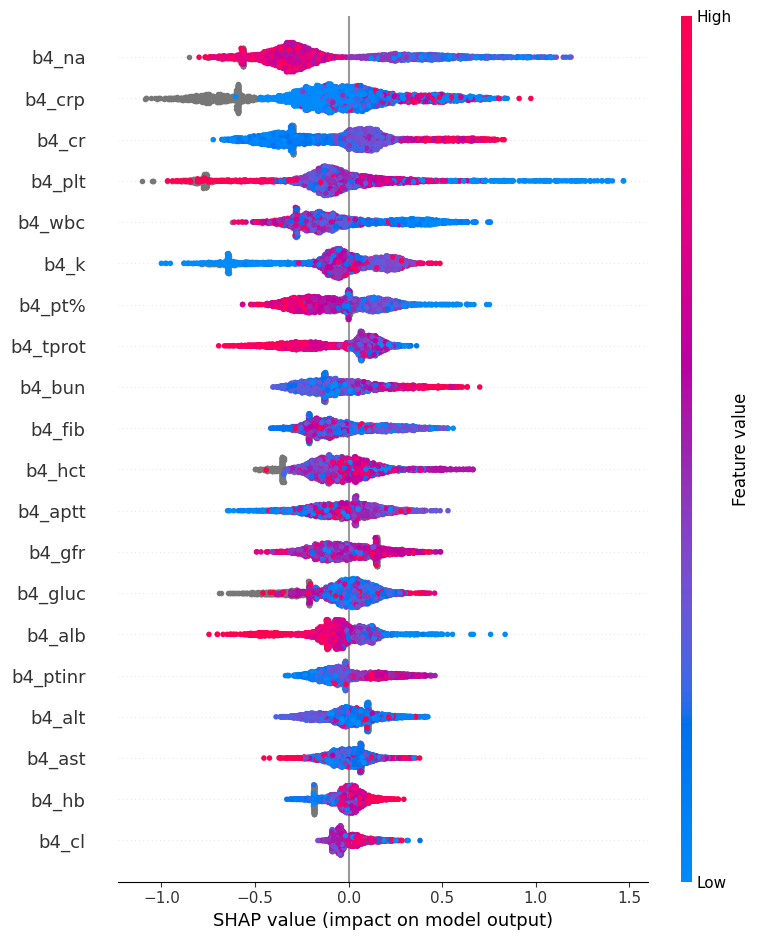

In [324]:
model_func.shap_summary_plot('xgbm_8.sav',X_train_75_complete)

# Try different Variations of input variable  

In [325]:

#8a
X_train_8a=X_train_75_complete[['b4_ica']]
X_test_8a=X_test_75_complete[['b4_ica']]
#8b
X_train_8b=X_train_75_complete[['b4_ica','optype_07']]
X_test_8b=X_test_75_complete[['b4_ica','optype_07']]
#8c
X_train_8c=X_train_75_complete[['b4_ica','optype_07','b4_crp']]
X_test_8c=X_test_75_complete[['b4_ica','optype_07','b4_crp']]
#8d
X_train_8d=X_train_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc']]
X_test_8d=X_test_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc']]
#8e
X_train_8e=X_train_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc','b4_alb']]
X_test_8e=X_test_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc','b4_alb']]
#8f
X_train_8f=X_train_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc','b4_alb','b4_na']]
X_test_8f=X_test_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc','b4_alb','b4_na']]
#8g
X_train_8g=X_train_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc','b4_alb','b4_na','asa_02']]
X_test_8g=X_test_75_complete[['b4_ica','optype_07','b4_crp','b4_wbc','b4_alb','b4_na','asa_02']]
#8h
X_train_8h = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt']]
X_test_8h = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt']]
#8i
X_train_8i = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age']]
X_test_8i = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age']]
#8j
X_train_8j = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p']]
X_test_8j = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p']]
#8k
X_train_8k = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%']]
X_test_8k = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%']]
#8l
X_train_8l = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib']]
X_test_8l = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib']]
#8m
X_train_8m = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun']]
X_test_8m = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun']]
#8n
X_train_8n = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr']]
X_test_8n = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr']]
#8o
X_train_8o = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot']]
X_test_8o = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot']]
#8p
X_train_8p = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k']]
X_test_8p = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k']]
#8q
X_train_8q = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc']]
X_test_8q = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc']]
#8r
X_train_8r = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc', 'b4_aptt']]
X_test_8r = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc', 'b4_aptt']]
#8s
X_train_8s = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc', 'b4_aptt', 'bmi']]
X_test_8s = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc', 'b4_aptt', 'bmi']]
#8t
X_train_8t = X_train_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc', 'b4_aptt', 'bmi', 'b4_ast']]
X_test_8t = X_test_75_complete[['b4_ica', 'optype_07', 'b4_crp', 'b4_wbc', 'b4_alb', 'b4_na', 'asa_02', 'b4_plt', 'age', 'b4_p', 'b4_pt%', 'b4_fib', 'b4_bun', 'b4_cr', 'b4_tprot', 'b4_k', 'b4_gluc', 'b4_aptt', 'bmi', 'b4_ast']]

def train_and_evaluate(X_train, y_train, X_test, y_test, variation_label):
    # Define the model
    gbm = XGBClassifier()
    
    # Define hyperparameters grid
    params = {'max_depth': [4, 6, 8, 10, 12],
              'max_leaves': [40, 60, 80, 100],
              'n_estimators': [50, 100, 200, 500],
              'learning_rate': [0, 0.1, 0.2, 0.3, 0.01, 0.02, 0.001],
              'subsample': sp_uniform(loc=0.2, scale=0.8),
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
              'reg_alpha': [10, 0, 0.01, 0.03],
              'reg_lambda': [10, 0, 0.01, 0.03],
              'random_state': [42]}
    
    # Perform randomized search for best hyperparameters
    model = RandomizedSearchCV(gbm, params)
    model.fit(X_train, y_train)
    
    # Get the best hyperparameters
    best_params = model.best_params_
    
    # Print best parameters
    print("Best parameters found for Variation {}: {}".format(variation_label, best_params))
    
    # Initialize model with best hyperparameters
    model = XGBClassifier(**best_params)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    model_func.fit_model(model, 'XGB Classifier', 'xgbm_{}.sav'.format(variation_label), X_train, y_train)
    model_func.c_matrix('xgbm_{}.sav'.format(variation_label), 'Post-Operative Complications {}'.format(variation_label), y_test, X_test)
    model_func.plot_auc('xgbm_{}.sav'.format(variation_label), y_test, X_test)
    model_func.feature_importance('xgbm_{}.sav'.format(variation_label), X_train, 'Top Important Features{}'.format(variation_label))
    model_func.shap_summary_plot('xgbm_{}.sav'.format(variation_label), X_train)



KeyError: "None of [Index(['b4_ica'], dtype='object')] are in the [columns]"

## Variation 8a

Best parameters found for Variation 8a: {'colsample_bytree': 0.654255639403491, 'gamma': 200, 'learning_rate': 0.02, 'max_depth': 10, 'max_leaves': 80, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.35036687171951253}
XGB Classifier
Start Time: 2024-04-29 13:03:46.705770
End Time: 2024-04-29 13:03:46.729778
Total time taken:0:00:00.024008
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       792
           1       0.00      0.00      0.00        53

    accuracy                           0.94       845
   macro avg       0.47      0.50      0.48       845
weighted avg       0.88      0.94      0.91       845



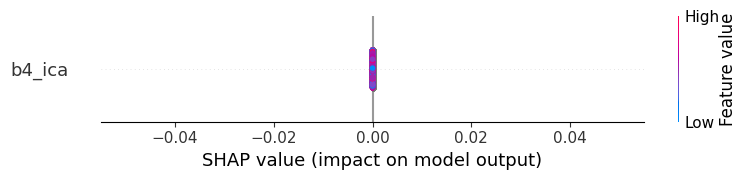

In [ ]:
train_and_evaluate(X_train_8a, y_train, X_test_8a, y_test, "8a")

## Variation 8b

Best parameters found for Variation 8b: {'colsample_bytree': 0.9476087207468069, 'gamma': 0, 'learning_rate': 0, 'max_depth': 6, 'max_leaves': 60, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0, 'subsample': 0.982193032234425}
XGB Classifier
Start Time: 2024-04-29 13:03:49.500517
End Time: 2024-04-29 13:03:49.537246
Total time taken:0:00:00.036729
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       792
           1       0.00      0.00      0.00        53

    accuracy                           0.94       845
   macro avg       0.47      0.50      0.48       845
weighted avg       0.88      0.94      0.91       845



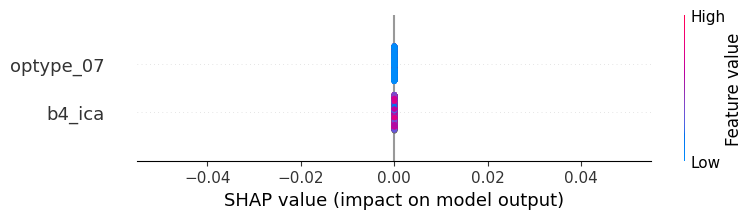

In [ ]:
train_and_evaluate(X_train_8b, y_train, X_test_8b, y_test, "8b")

## Variation 8c

Best parameters found for Variation 8c: {'colsample_bytree': 0.875170291933746, 'gamma': 3.2, 'learning_rate': 0.2, 'max_depth': 6, 'max_leaves': 80, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8901242149779722}
XGB Classifier
Start Time: 2024-04-29 13:03:52.950274
End Time: 2024-04-29 13:03:52.969370
Total time taken:0:00:00.019096
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.63      0.23      0.33        53

    accuracy                           0.94       845
   macro avg       0.79      0.61      0.65       845
weighted avg       0.93      0.94      0.93       845



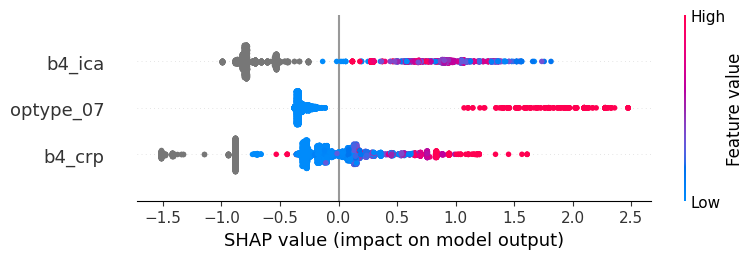

In [ ]:
train_and_evaluate(X_train_8c, y_train, X_test_8c, y_test, "8c")

## Variation 8d

Best parameters found for Variation 8d: {'colsample_bytree': 0.8359023938752961, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 6, 'max_leaves': 80, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.03, 'subsample': 0.8792446543126078}
XGB Classifier
Start Time: 2024-04-29 13:03:57.418945
End Time: 2024-04-29 13:03:57.454396
Total time taken:0:00:00.035451
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       1.00      0.19      0.32        53

    accuracy                           0.95       845
   macro avg       0.97      0.59      0.65       845
weighted avg       0.95      0.95      0.93       845



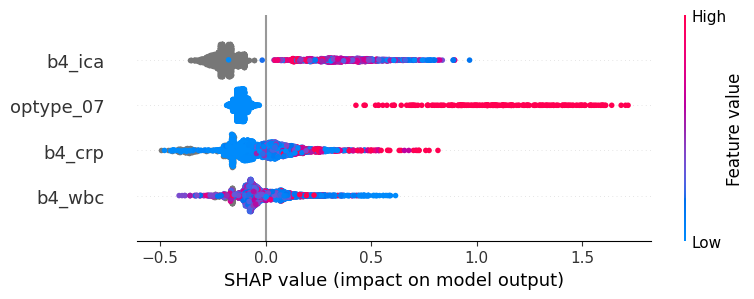

In [ ]:
train_and_evaluate(X_train_8d, y_train, X_test_8d, y_test, "8d")

## Variation 8e

Best parameters found for Variation 8e: {'colsample_bytree': 0.43934087526124566, 'gamma': 6.4, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 100, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0.03, 'subsample': 0.9024454133613384}
XGB Classifier
Start Time: 2024-04-29 13:04:00.797324
End Time: 2024-04-29 13:04:00.813953
Total time taken:0:00:00.016629
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.82      0.26      0.40        53

    accuracy                           0.95       845
   macro avg       0.89      0.63      0.69       845
weighted avg       0.94      0.95      0.94       845



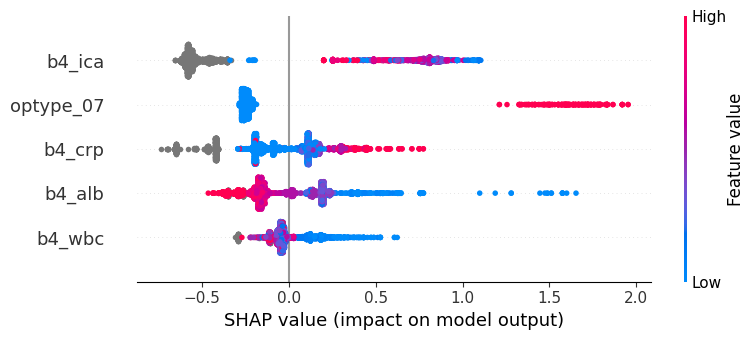

In [ ]:
train_and_evaluate(X_train_8e, y_train, X_test_8e, y_test, "8e")

## Variation 8f

Best parameters found for Variation 8f: {'colsample_bytree': 0.6714001789331043, 'gamma': 0.1, 'learning_rate': 0.02, 'max_depth': 10, 'max_leaves': 40, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.6835615005642643}
XGB Classifier
Start Time: 2024-04-29 13:04:05.334846
End Time: 2024-04-29 13:04:05.553675
Total time taken:0:00:00.218829
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.83      0.28      0.42        53

    accuracy                           0.95       845
   macro avg       0.89      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



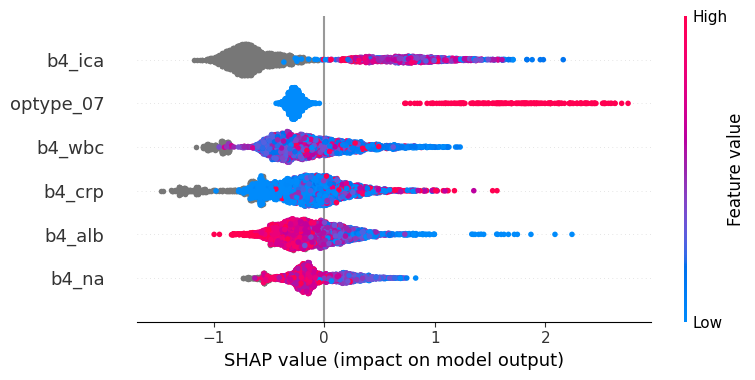

In [ ]:
train_and_evaluate(X_train_8f, y_train, X_test_8f, y_test, "8f")

## Variation 8g

Best parameters found for Variation 8g: {'colsample_bytree': 0.8684772512916114, 'gamma': 0.2, 'learning_rate': 0.02, 'max_depth': 12, 'max_leaves': 80, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0.03, 'subsample': 0.8791029481288832}
XGB Classifier
Start Time: 2024-04-29 13:04:09.415996
End Time: 2024-04-29 13:04:09.480903
Total time taken:0:00:00.064907
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.90      0.17      0.29        53

    accuracy                           0.95       845
   macro avg       0.92      0.58      0.63       845
weighted avg       0.94      0.95      0.93       845



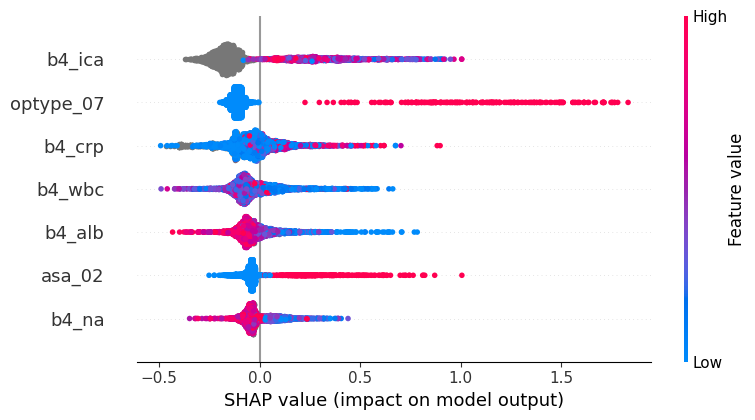

In [ ]:
train_and_evaluate(X_train_8g, y_train, X_test_8g, y_test, "8g")

## Variation 8h

Best parameters found for Variation 8h: {'colsample_bytree': 0.6822359691453722, 'gamma': 0.4, 'learning_rate': 0.02, 'max_depth': 8, 'max_leaves': 60, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 10, 'subsample': 0.936772641427488}
XGB Classifier
Start Time: 2024-04-29 13:04:15.307090
End Time: 2024-04-29 13:04:15.868058
Total time taken:0:00:00.560968
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.70      0.26      0.38        53

    accuracy                           0.95       845
   macro avg       0.83      0.63      0.68       845
weighted avg       0.94      0.95      0.94       845



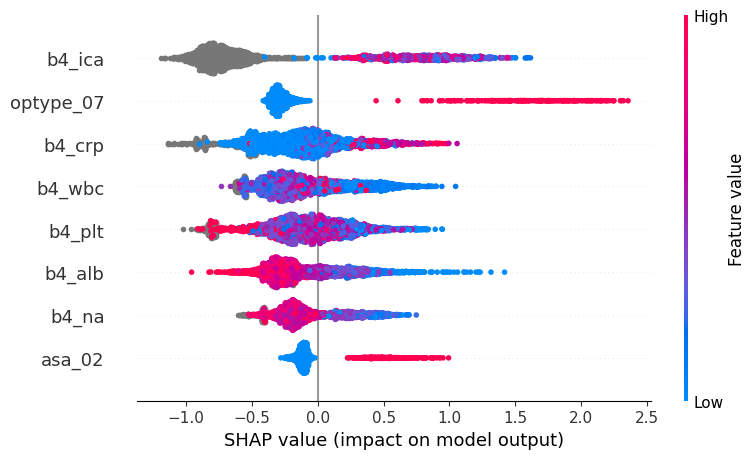

In [ ]:

train_and_evaluate(X_train_8h, y_train, X_test_8h, y_test, "8h")

## Variation 8i

Best parameters found for Variation 8i: {'colsample_bytree': 0.9157602442688595, 'gamma': 3.2, 'learning_rate': 0.02, 'max_depth': 10, 'max_leaves': 100, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.7478924497553658}
XGB Classifier
Start Time: 2024-04-29 13:04:23.132079
End Time: 2024-04-29 13:04:23.244758
Total time taken:0:00:00.112679
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       792
           1       0.89      0.30      0.45        53

    accuracy                           0.95       845
   macro avg       0.92      0.65      0.71       845
weighted avg       0.95      0.95      0.94       845



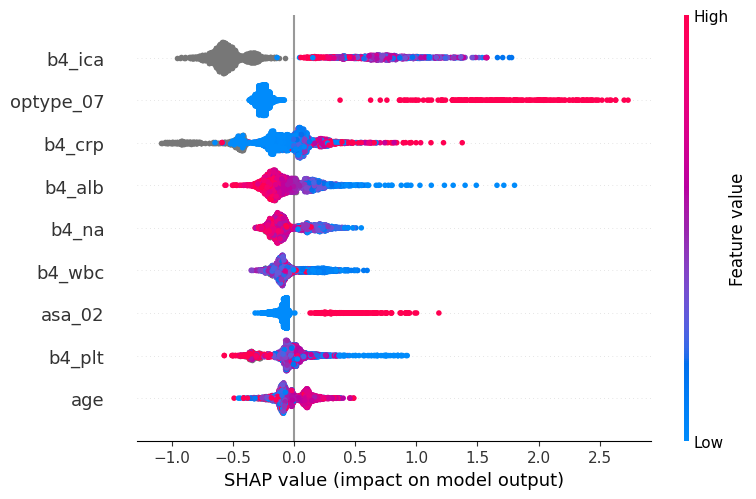

In [ ]:
train_and_evaluate(X_train_8i, y_train, X_test_8i, y_test, "8i")

## Variation 8j

Best parameters found for Variation 8j: {'colsample_bytree': 0.9642763600642195, 'gamma': 6.4, 'learning_rate': 0.3, 'max_depth': 12, 'max_leaves': 80, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0, 'subsample': 0.7744164574144201}
XGB Classifier
Start Time: 2024-04-29 13:04:26.379720
End Time: 2024-04-29 13:04:26.394173
Total time taken:0:00:00.014453
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       792
           1       0.79      0.28      0.42        53

    accuracy                           0.95       845
   macro avg       0.87      0.64      0.70       845
weighted avg       0.94      0.95      0.94       845



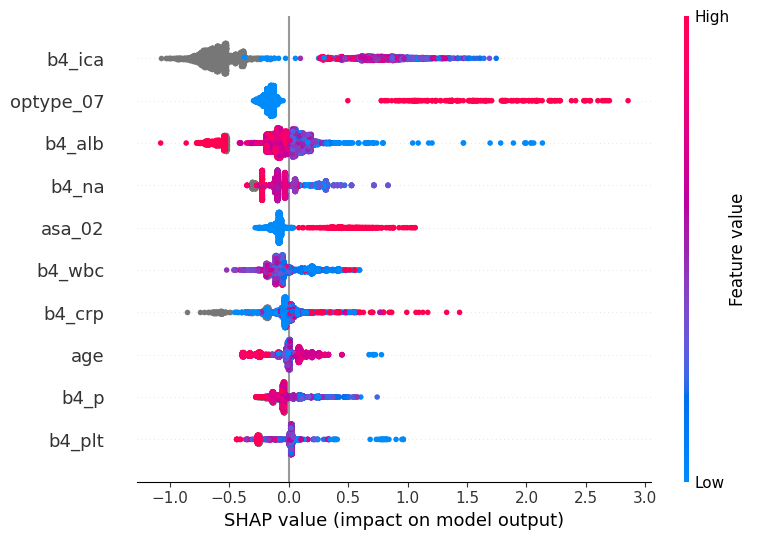

In [ ]:
train_and_evaluate(X_train_8j, y_train, X_test_8j, y_test, "8j")

## Variation 8k

Best parameters found for Variation 8k: {'colsample_bytree': 0.8612578233675496, 'gamma': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'max_leaves': 60, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 10, 'subsample': 0.8444485825152894}
XGB Classifier
Start Time: 2024-04-29 13:04:32.818565
End Time: 2024-04-29 13:04:33.219720
Total time taken:0:00:00.401155
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       792
           1       0.81      0.32      0.46        53

    accuracy                           0.95       845
   macro avg       0.88      0.66      0.72       845
weighted avg       0.95      0.95      0.94       845



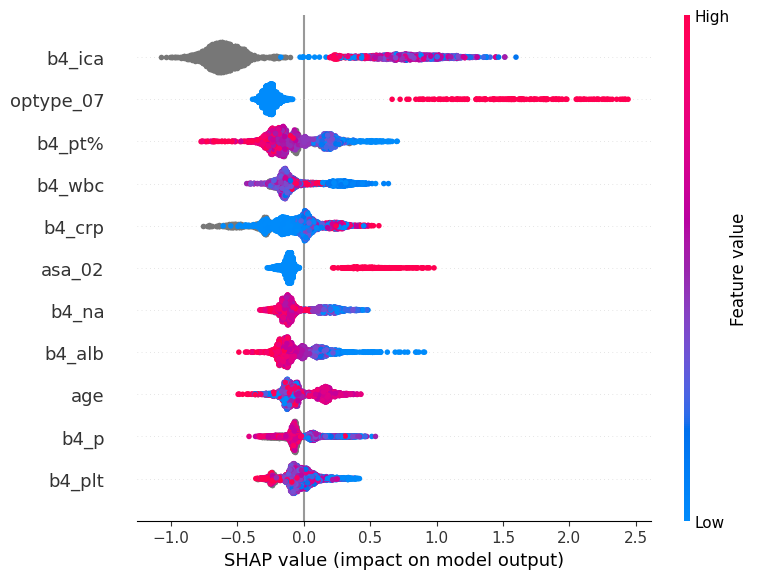

In [ ]:

train_and_evaluate(X_train_8k, y_train, X_test_8k, y_test, "8k")

## Variation 8l

Best parameters found for Variation 8l: {'colsample_bytree': 0.5564351212565228, 'gamma': 1.6, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 60, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0.03, 'subsample': 0.4307652140382464}
XGB Classifier
Start Time: 2024-04-29 13:04:38.316283
End Time: 2024-04-29 13:04:38.362570
Total time taken:0:00:00.046287
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.74      0.32      0.45        53

    accuracy                           0.95       845
   macro avg       0.85      0.66      0.71       845
weighted avg       0.94      0.95      0.94       845



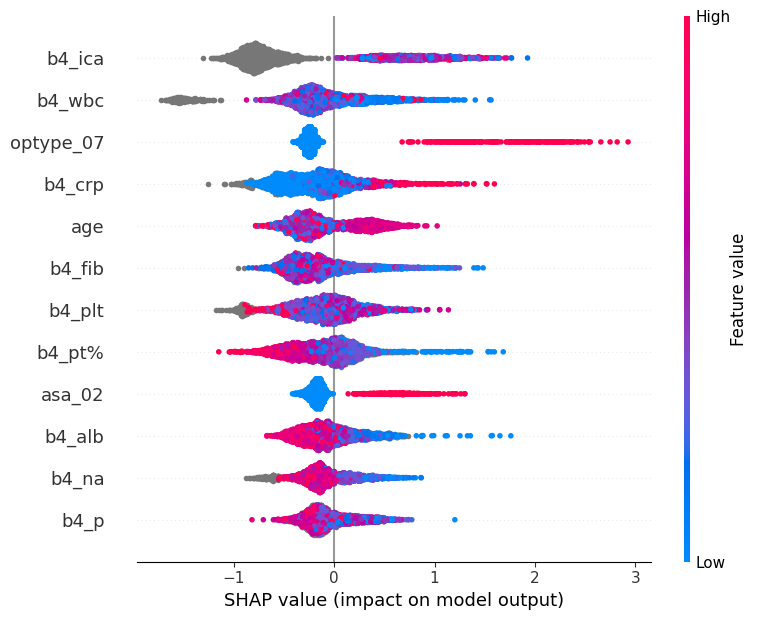

In [ ]:
train_and_evaluate(X_train_8l, y_train, X_test_8l, y_test, "8l")

## Variation 8m

Best parameters found for Variation 8m: {'colsample_bytree': 0.8336213570387707, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 40, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.6109340973507502}
XGB Classifier
Start Time: 2024-04-29 13:04:42.797922
End Time: 2024-04-29 13:04:42.857686
Total time taken:0:00:00.059764
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.83      0.28      0.42        53

    accuracy                           0.95       845
   macro avg       0.89      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



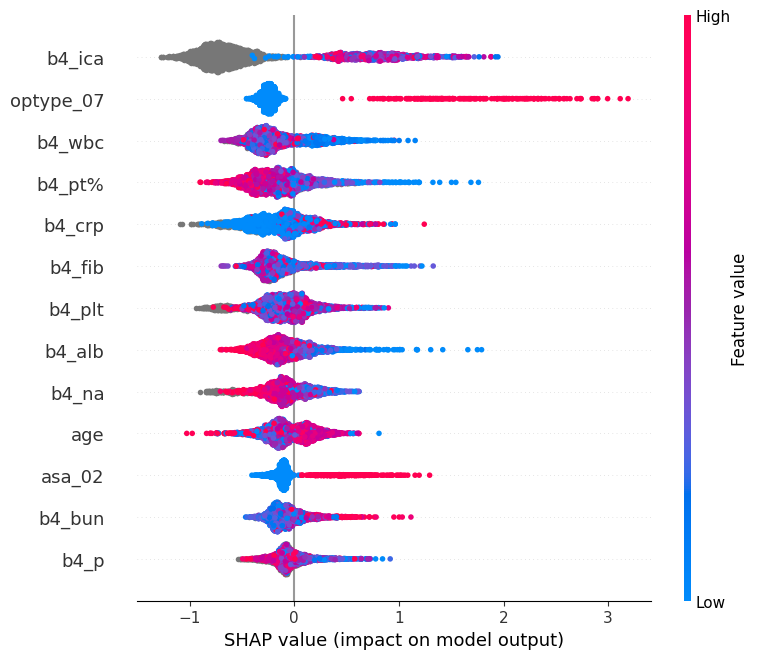

In [ ]:
train_and_evaluate(X_train_8m, y_train, X_test_8m, y_test, "8m")


## Variation 8n

Best parameters found for Variation 8n: {'colsample_bytree': 0.400499184753589, 'gamma': 1.6, 'learning_rate': 0.02, 'max_depth': 8, 'max_leaves': 80, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.03, 'subsample': 0.4769381523094916}
XGB Classifier
Start Time: 2024-04-29 13:04:57.204493
End Time: 2024-04-29 13:04:57.336488
Total time taken:0:00:00.131995
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       792
           1       0.88      0.28      0.43        53

    accuracy                           0.95       845
   macro avg       0.92      0.64      0.70       845
weighted avg       0.95      0.95      0.94       845



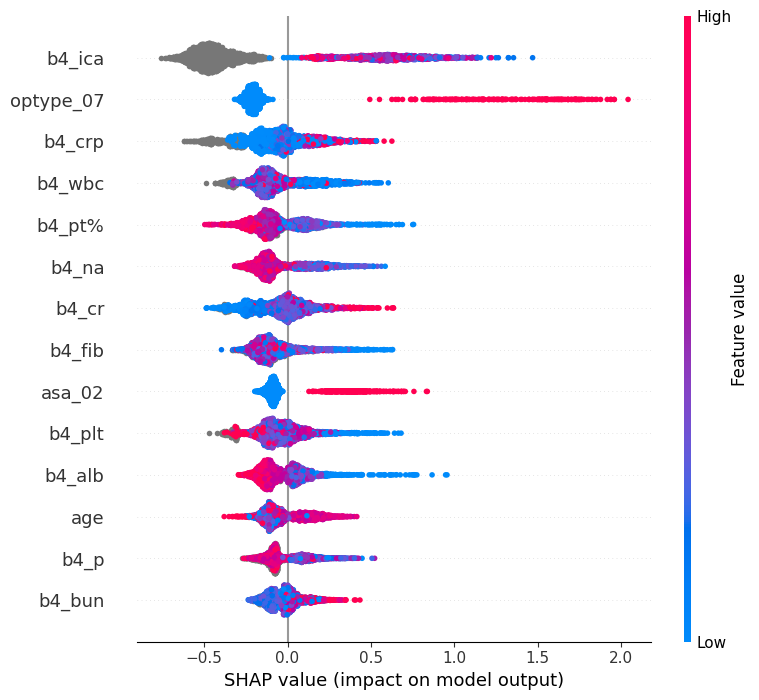

In [ ]:
train_and_evaluate(X_train_8n, y_train, X_test_8n, y_test, "8n")

## Variation 8o

Best parameters found for Variation 8o: {'colsample_bytree': 0.9602353653510984, 'gamma': 3.2, 'learning_rate': 0.02, 'max_depth': 4, 'max_leaves': 80, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.03, 'subsample': 0.3243041072101008}
XGB Classifier
Start Time: 2024-04-29 13:05:04.025427
End Time: 2024-04-29 13:05:04.113639
Total time taken:0:00:00.088212
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.73      0.30      0.43        53

    accuracy                           0.95       845
   macro avg       0.84      0.65      0.70       845
weighted avg       0.94      0.95      0.94       845



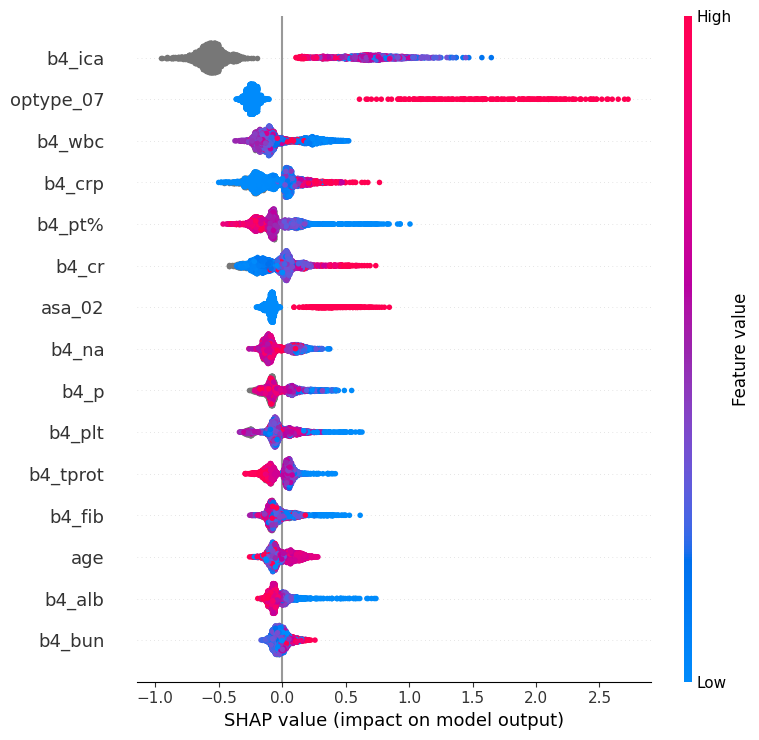

In [ ]:

train_and_evaluate(X_train_8o, y_train, X_test_8o, y_test, "8o")

## Variation 8p

Best parameters found for Variation 8p: {'colsample_bytree': 0.5204841127838225, 'gamma': 0.2, 'learning_rate': 0.02, 'max_depth': 10, 'max_leaves': 60, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.03, 'reg_lambda': 0.01, 'subsample': 0.8896734856246231}
XGB Classifier
Start Time: 2024-04-29 13:05:11.776909
End Time: 2024-04-29 13:05:11.977832
Total time taken:0:00:00.200923
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       792
           1       0.81      0.25      0.38        53

    accuracy                           0.95       845
   macro avg       0.88      0.62      0.68       845
weighted avg       0.94      0.95      0.94       845



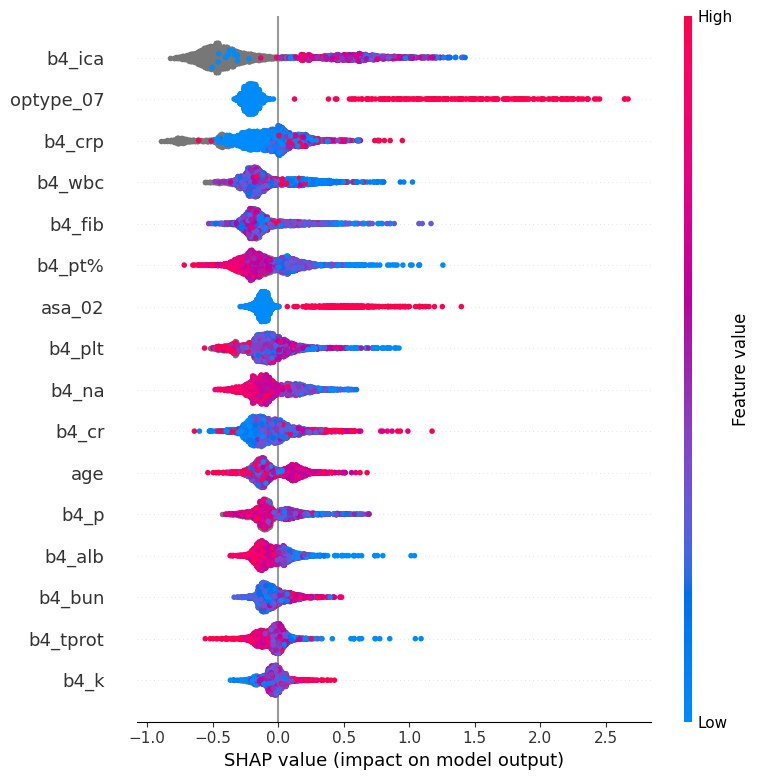

In [ ]:
train_and_evaluate(X_train_8p, y_train, X_test_8p, y_test, "8p")

## Variation 8q

Best parameters found for Variation 8q: {'colsample_bytree': 0.9147580570110825, 'gamma': 0.4, 'learning_rate': 0.3, 'max_depth': 4, 'max_leaves': 80, 'n_estimators': 50, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.8570733511253696}
XGB Classifier
Start Time: 2024-04-29 13:05:17.498964
End Time: 2024-04-29 13:05:17.536478
Total time taken:0:00:00.037514
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       792
           1       0.76      0.36      0.49        53

    accuracy                           0.95       845
   macro avg       0.86      0.68      0.73       845
weighted avg       0.95      0.95      0.94       845



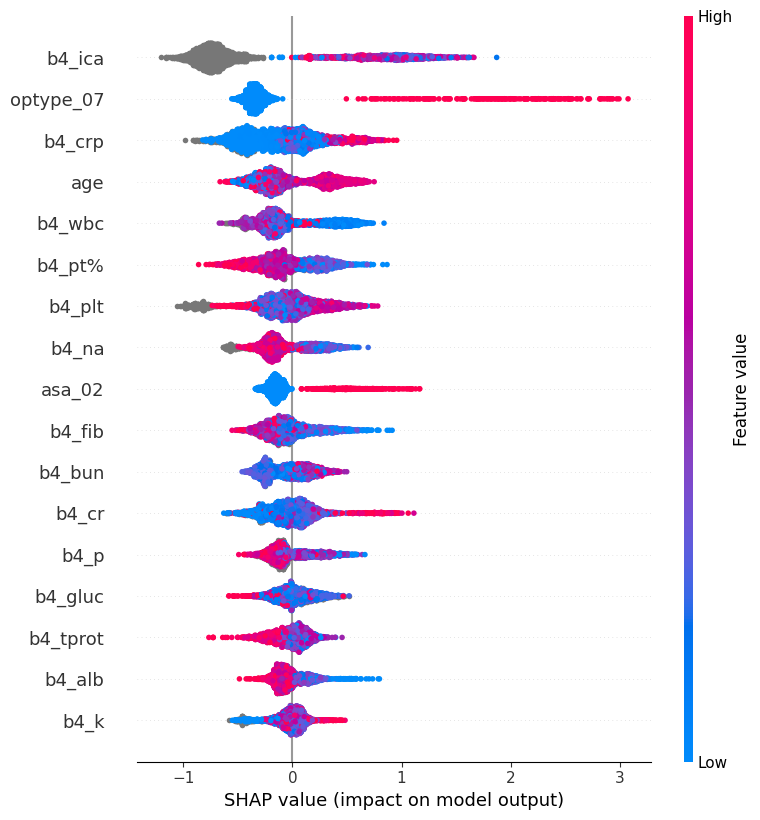

In [ ]:
train_and_evaluate(X_train_8q, y_train, X_test_8q, y_test, "8q")

## Variation 8r

Best parameters found for Variation 8r: {'colsample_bytree': 0.6917196013436528, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'max_leaves': 40, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 10, 'reg_lambda': 0.01, 'subsample': 0.6374917371809597}
XGB Classifier
Start Time: 2024-04-29 13:05:23.999815
End Time: 2024-04-29 13:05:24.169200
Total time taken:0:00:00.169385
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       792
           1       0.76      0.30      0.43        53

    accuracy                           0.95       845
   macro avg       0.86      0.65      0.70       845
weighted avg       0.94      0.95      0.94       845



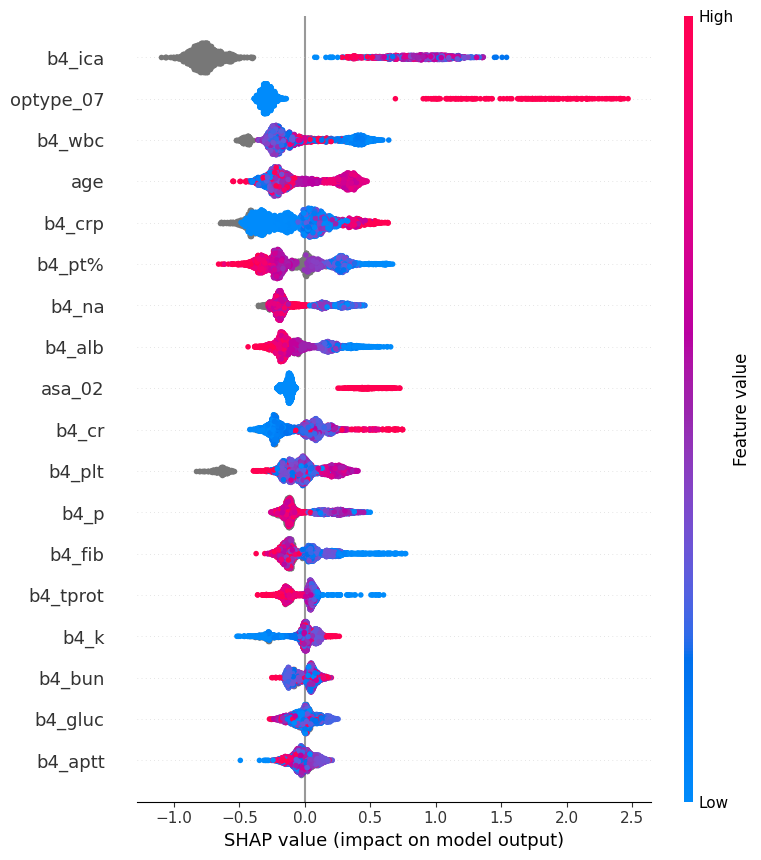

In [ ]:
train_and_evaluate(X_train_8r, y_train, X_test_8r, y_test, "8r")

## Variation 8s

Best parameters found for Variation 8s: {'colsample_bytree': 0.8920375583461694, 'gamma': 12.8, 'learning_rate': 0.01, 'max_depth': 10, 'max_leaves': 100, 'n_estimators': 500, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 0.9901694487941293}
XGB Classifier
Start Time: 2024-04-29 13:05:32.222753
End Time: 2024-04-29 13:05:32.385628
Total time taken:0:00:00.162875
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       792
           1       1.00      0.25      0.39        53

    accuracy                           0.95       845
   macro avg       0.98      0.62      0.68       845
weighted avg       0.95      0.95      0.94       845



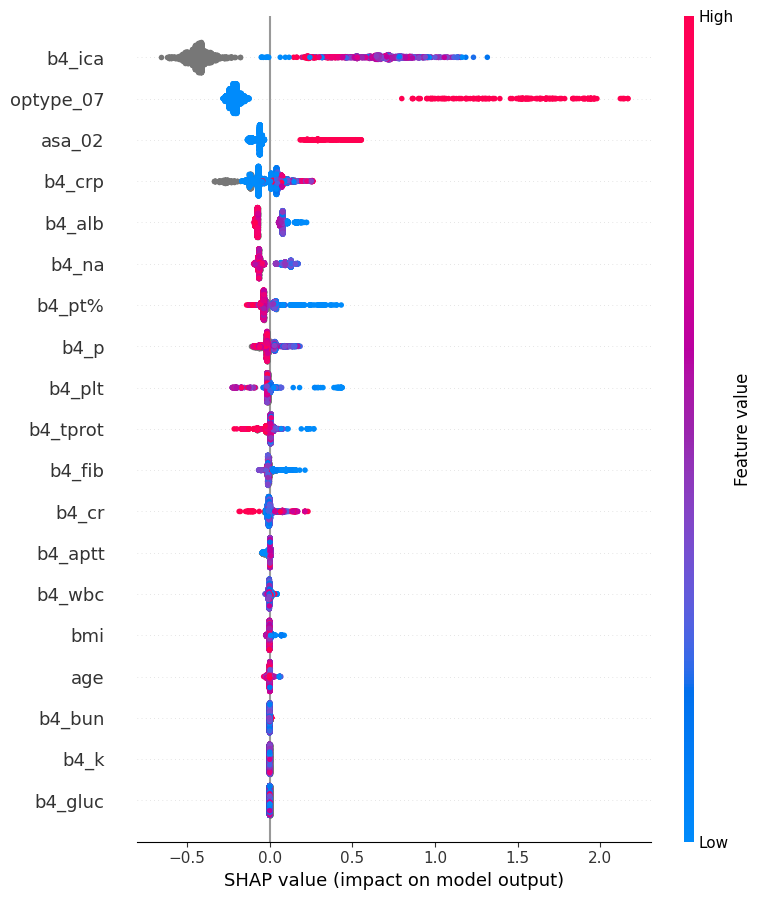

In [ ]:
train_and_evaluate(X_train_8s, y_train, X_test_8s, y_test, "8s")

## Variation 8t

Best parameters found for Variation 8t: {'colsample_bytree': 0.9434917243400671, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'max_leaves': 40, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 10, 'subsample': 0.8420488693928423}
XGB Classifier
Start Time: 2024-04-29 13:05:36.647920
End Time: 2024-04-29 13:05:36.765422
Total time taken:0:00:00.117502
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       792
           1       0.81      0.32      0.46        53

    accuracy                           0.95       845
   macro avg       0.88      0.66      0.72       845
weighted avg       0.95      0.95      0.94       845



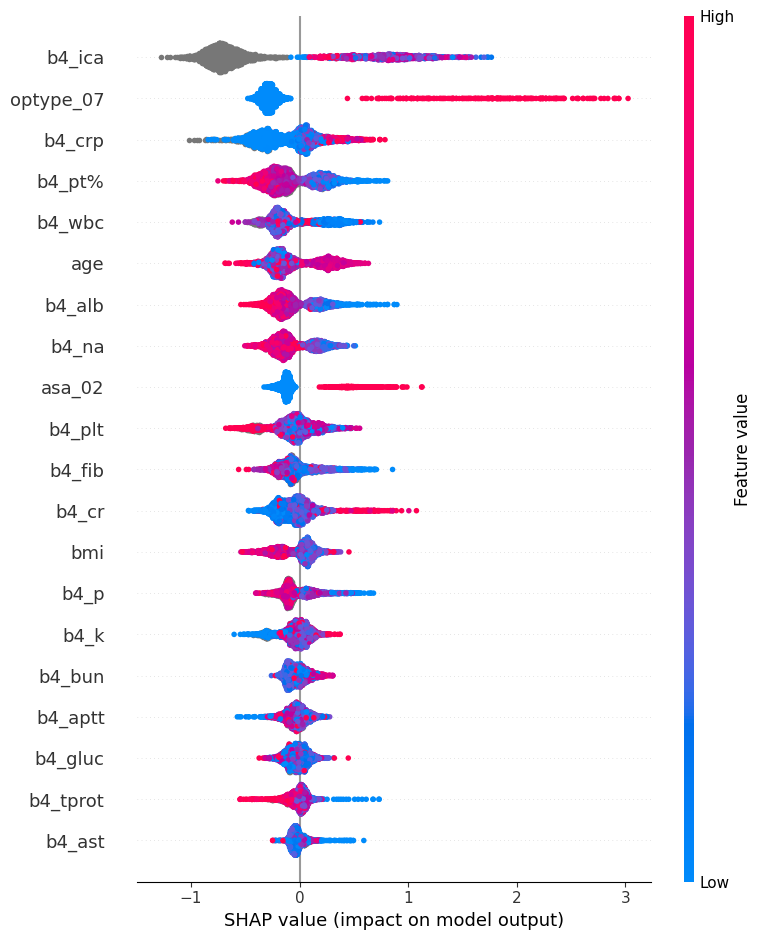

In [ ]:
train_and_evaluate(X_train_8t, y_train, X_test_8t, y_test, "8t")